# Simple Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Data-preprocessing
* 결측치 제거
* 이상치 제거: Tukey Fence, ✔️<b>Z-score</b>
* 정규화 진행: ✔️<b>Min-Max Scaling</b>, Z-score

### 결측치 제거

In [2]:
df = pd.read_csv('ozone.csv')
training_data = df[['Temp', 'Ozone']]
display(df)

# 결측치 확인
print('온도의 결측치: {}개'.format(training_data['Temp'].isnull().sum()))
print('오존의 결측치: {}개'.format(training_data['Ozone'].isnull().sum()))

# 결측치 제거
training_data = training_data.dropna(how='any')
display(training_data)

# scikit-learn용 학습 데이터 (결측치만 처리되고 이상치, 정규화는 처리되지 않은 데이터)
training_data_sl = training_data.copy()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


온도의 결측치: 0개
오존의 결측치: 37개


,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


### 이상치 제거
#### 이상치 확인

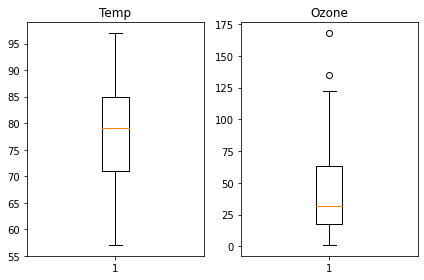

In [14]:
fig = plt.figure()
fig_tmp = fig.add_subplot(1,2, 1)
fig_ozone = fig.add_subplot(1,2, 2)

fig_tmp.set_title('Temp')
fig_ozone.set_title('Ozone')

fig_tmp.boxplot(training_data['Temp'])
fig_ozone.boxplot(training_data['Ozone'])

fig.tight_layout()
plt.show()

#### Tukey Fence

In [69]:
iqr_value = np.percentile(training_data['Ozone'], 75) - np.percentile(training_data['Ozone'], 25)
upper_fence = np.percentile(training_data['Ozone'], 75) + (iqr_value * 1.5)
lower_fence = np.percentile(training_data['Ozone'], 25) - (iqr_value * 1.5)

training_data = training_data[(training_data['Ozone'] <= upper_fence) & (training_data['Ozone'] >= lower_fence)]
display(training_data)

,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


#### ✔️Z-score

In [3]:
zscore_threshold = 1.8

# Temp outlier
tmp = ~(np.abs(stats.zscore(training_data['Temp'])) > zscore_threshold)
training_data = training_data.loc[tmp]
display(training_data)

# Ozone outlier
tmp = ~(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)
training_data = training_data.loc[tmp]
display(training_data)

,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


### 정규화 (z-score 이상치 사용)
#### ✔️ Min-Max Normalization
* Python

In [4]:
# Temp Min-Max Normalization
x_scaled = (training_data['Temp'] - training_data['Temp'].min()) / (training_data['Temp'].max() - training_data['Temp'].min())
print(x_scaled)

# Ozone Min-Max Normalization
t_scaled = (training_data['Ozone'] - training_data['Ozone'].min()) / (training_data['Ozone'].max() - training_data['Ozone'].min())
print(t_scaled)

training_data = pd.DataFrame({'Temp': x_scaled, 'Ozone': t_scaled})
display(training_data)

0      0.181818
1      0.333333
2      0.393939
3      0.030303
5      0.151515
         ...   
147    0.060606
148    0.272727
150    0.424242
151    0.454545
152    0.212121
Name: Temp, Length: 103, dtype: float64
0      0.397849
1      0.344086
2      0.086022
3      0.150538
5      0.258065
         ...   
147    0.107527
148    0.279570
150    0.107527
151    0.150538
152    0.172043
Name: Ozone, Length: 103, dtype: float64


,Temp,Ozone
0,0.181818,0.397849
1,0.333333,0.344086
2,0.393939,0.086022
3,0.030303,0.150538
5,0.151515,0.258065
...,...,...
147,0.060606,0.107527
148,0.272727,0.279570
150,0.424242,0.107527
151,0.454545,0.150538


* Library

In [74]:
# Temp Min-Max Normalization
scaler_x = MinMaxScaler() 
scaler_x.fit(training_data['Temp'].values.reshape(-1,1)) 
print(scaler_x.n_samples_seen_, scaler_x.data_max_, scaler_x.data_min_, scaler_x.feature_range) 
training_data['Temp'] = scaler_x.transform(training_data['Temp'].values.reshape(-1,1))

# Ozone Min-Max Normalization
scaler_t = MinMaxScaler() 
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1)) 
training_data['Ozone'] = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

display(training_data)

103 [94.] [61.] (0, 1)


,Temp,Ozone
0,0.181818,0.397849
1,0.333333,0.344086
2,0.393939,0.086022
3,0.030303,0.150538
5,0.151515,0.258065
...,...,...
147,0.060606,0.107527
148,0.272727,0.279570
150,0.424242,0.107527
151,0.454545,0.150538


#### Z-score Normalization = Standardization
* python

In [108]:
# Temp z-score Normalization
x_scaled = (training_data['Temp'] - training_data['Temp'].mean()) / training_data['Temp'].std()
print(x_scaled)

# Ozone z-score Normalization
t_scaled = (training_data['Ozone'] - training_data['Ozone'].mean()) / training_data['Ozone'].std()
print(t_scaled)

result_zs = pd.DataFrame({'Temp': x_scaled, 'Ozone': t_scaled})
display(result_zs)

0     -1.251910
1     -0.667912
2     -0.434313
3     -1.835908
5     -1.368709
         ...   
147   -1.719108
148   -0.901511
150   -0.317513
151   -0.200714
152   -1.135110
Name: Temp, Length: 103, dtype: float64
0      0.160589
1     -0.038217
2     -0.992487
3     -0.753920
5     -0.356307
         ...   
147   -0.912965
148   -0.276785
150   -0.912965
151   -0.753920
152   -0.674397
Name: Ozone, Length: 103, dtype: float64


,Temp,Ozone
0,-1.251910,0.160589
1,-0.667912,-0.038217
2,-0.434313,-0.992487
3,-1.835908,-0.753920
5,-1.368709,-0.356307
...,...,...
147,-1.719108,-0.912965
148,-0.901511,-0.276785
150,-0.317513,-0.912965
151,-0.200714,-0.753920


* Library <br>
To obtain the same results with Pandas, we set the parameter ddof equal to 0 (default value is ddof=1) which represents the divisor used in the calculations (N-ddof).

```python
# population standard deviation with Pandas
df_cars.std(ddof=0)
```

👉🏼 <a href="https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475">참고자료</a>

In [109]:
# Temp z-score Normalization
scaler_x = StandardScaler()
training_data['Temp'] = scaler_x.fit_transform(training_data['Temp'].values.reshape(-1,1))
print(scaler_x.scale_, scaler_x.mean_)

# Ozone Min-Max Normalization
scaler_t = StandardScaler()
training_data['Ozone'] = scaler_t.fit_transform(training_data['Ozone'].values.reshape(-1,1))
print(scaler_t.scale_, scaler_t.mean_)

display(training_data)

[1.] [2.15577286e-18]
[1.] [-4.31154573e-18]


,Temp,Ozone
0,-1.258032,0.161374
1,-0.671178,-0.038404
2,-0.436437,-0.997341
3,-1.844885,-0.757607
5,-1.375402,-0.358050
...,...,...
147,-1.727514,-0.917429
148,-0.905920,-0.278138
150,-0.319066,-0.917429
151,-0.201695,-0.757607


## Tensorflow

In [5]:
# 1. training data set
x_data = training_data['Temp'].values.reshape(-1, 1)
t_data = training_data['Ozone'].values.reshape(-1, 1)

# 2. X, T
X = tf.placeholder(shape=[None, 1], dtype=tf.float32)
T = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 3. W, b
W = tf.Variable(tf.random.normal([1, 1]))
b = tf.Variable(tf.random.normal([1]))

# 4. model
H = tf.matmul(X, W) + b

# 5. loss function
loss = tf.reduce_mean(tf.square(H - T))

# 6. gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# 7. learning
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], feed_dict={X: x_data, T: t_data})
    
    if step % 30000 == 0:
        print('W: {}, b: {}, loss: {}'.format(W_val, b_val, loss_val))

W: [[0.33226928]], b: [1.090131], loss: 0.8622759580612183
W: [[0.18682173]], b: [0.27725455], loss: 0.055262960493564606
W: [[0.35080722]], b: [0.18914384], loss: 0.04361555725336075
W: [[0.47064778]], b: [0.12506908], loss: 0.037408679723739624
W: [[0.5581318]], b: [0.07829573], loss: 0.0341009646654129
W: [[0.621985]], b: [0.04415524], loss: 0.03233844414353371
W: [[0.66857797]], b: [0.01923595], loss: 0.03139938786625862
W: [[0.7025895]], b: [0.00104852], loss: 0.030898841097950935
W: [[0.7274064]], b: [-0.01221844], loss: 0.030632097274065018
W: [[0.7455427]], b: [-0.0218988], loss: 0.030489742755889893


## Python

In [6]:
# 1. training data set
x_data = training_data['Temp'].values.reshape(-1, 1)
t_data = training_data['Ozone'].values.reshape(-1, 1)

# 2. W, b
W = np.random.rand(1, 1)
b = np.random.rand(1)

# 3. model
def predict(x):
    y = np.dot(x, W) + b
    
    return y

# 4. loss function
def loss_func(input_obj):
    input_W = input_obj[0]
    input_b = input_obj[1]
    
    y = np.dot(x_data, input_W) + input_b
    
    return np.mean(np.power((t_data - y), 2))

# 5. 다변수 함수(W, b)에 대한 수치미분
def numerical_derivative(f, x):
    
    delta_x = 1e-4
    derivative_x = np.zeros_like(x) 
    
    it = np.nditer(x, flags=['multi_index'])
    
    while not it.finished: 
        idx = it.multi_index 
        tmp = x[idx]                        

        x[idx] = tmp + delta_x 
        fx_plus_delta = f(x) 
        
        x[idx] = tmp - delta_x
        fx_minus_delta = f(x) 
        
        derivative_x[idx] = (fx_plus_delta - fx_minus_delta) / (2 * delta_x)
        
        x[idx] = tmp 
    
        it.iternext()
        
    return derivative_x

# 6. learning rate
learning_rate = 1e-4

# 7. learning
for step in range(600000):

    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0) # [W b]
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    W = W - derivative_result[:1].reshape(1,1) 
    b = b - derivative_result[1:] 
    
    if step % 60000 == 0:
        print('W: {}, b: {}'.format(W, b))

W: [[0.23520281]], b: [0.10892604]
W: [[0.52800462]], b: [0.09440225]
W: [[0.65256969]], b: [0.02780194]
W: [[0.71895106]], b: [-0.00768972]
W: [[0.75432604]], b: [-0.02660342]
W: [[0.77317755]], b: [-0.03668262]
W: [[0.78322362]], b: [-0.04205388]
W: [[0.78857722]], b: [-0.04491626]
W: [[0.79143019]], b: [-0.04644163]
W: [[0.79295054]], b: [-0.04725451]


## Sklearn
결측치만 처리되고 이상치, 정규화는 처리되지 않은 데이터로 학습

In [7]:
# 1. training data set
training_data_x = training_data_sl['Temp'].values.reshape(-1, 1)
training_data_t = training_data_sl['Ozone'].values.reshape(-1, 1)

# 2. model
model = linear_model.LinearRegression()

# 3. learning
model.fit(training_data_x, training_data_t)
print('W: {}, b: {}'.format(model.coef_, model.intercept_))

W: [[2.4287033]], b: [-146.99549097]


## Visualization

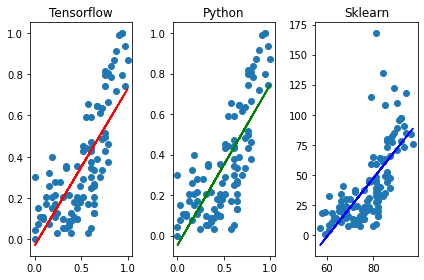

In [8]:
fig = plt.figure()
fig_tensorflow = fig.add_subplot(1,3, 1)
fig_python = fig.add_subplot(1,3, 2)
fig_sklearn = fig.add_subplot(1,3, 3)

fig_tensorflow.set_title('Tensorflow')
fig_tensorflow.scatter(x_data, t_data)
fig_tensorflow.plot(x_data, x_data*W_val + b_val, color='r')

fig_python.set_title('Python')
fig_python.scatter(x_data, t_data)
fig_python.plot(x_data, x_data*W + b, color='g')

fig_sklearn.set_title('Sklearn')
fig_sklearn.scatter(training_data_x, training_data_t)
fig_sklearn.plot(training_data_x, training_data_x*model.coef_ + model.intercept_, color='b')

fig.tight_layout()
plt.show()

## Prediction
온도가 화씨 82도일 때 오존량은? 

In [10]:
predict_data = np.array([[82]])

# Normalization
scaled_predict_data = (predict_data - training_data['Temp'].min()) / (training_data['Temp'].max() - training_data['Temp'].min())
scaled_tensorflow = sess.run(H, feed_dict={X: scaled_predict_data})
scaled_python = predict(scaled_predict_data)

# Denormalization
result_tensorflow = (scaled_tensorflow * (training_data['Temp'].max() - training_data['Temp'].min())) + training_data['Temp'].min()
result_python = (scaled_python * (training_data['Temp'].max() - training_data['Temp'].min())) + training_data['Temp'].min()

# result
print('tensorflow : {}'.format(result_tensorflow))
print('python : {}'.format(result_python))
print('sklearn : {}'.format(model.predict(predict_data)))

tensorflow : [[62.18525]]
python : [[65.04069308]]
sklearn : [[52.15818003]]
